# Load Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import math

from sklearn.preprocessing import RobustScaler
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir ='~/aiffel/kaggle_kakr_housing/data'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.shape, test.shape

((15035, 21), (6468, 20))

# EDA

<AxesSubplot:>

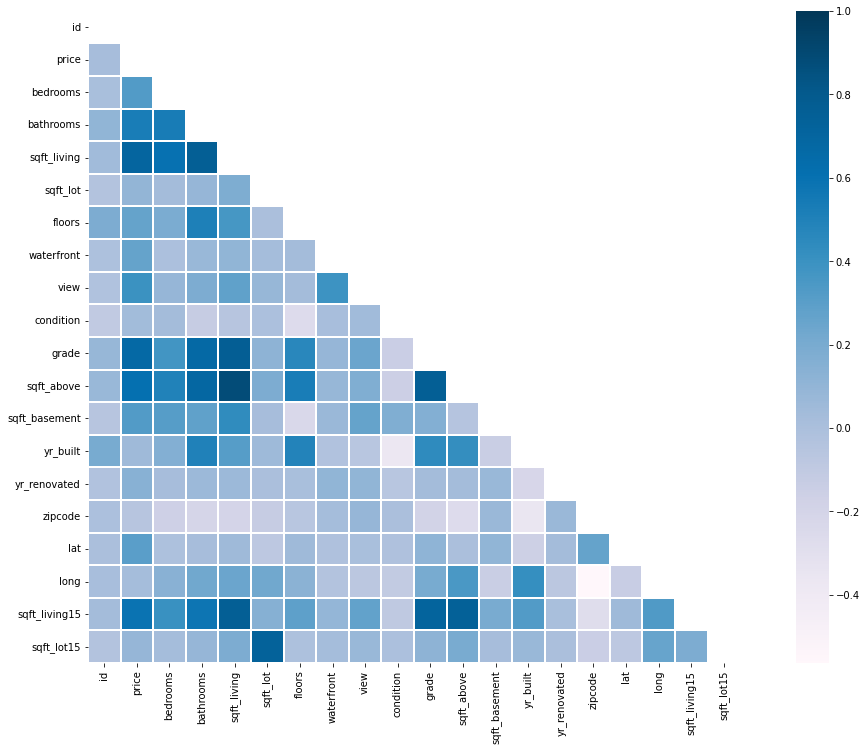

In [3]:
colormap = plt.cm.PuBu

mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 12))
sns.heatmap(train.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", 
            annot = False, annot_kws = {"size" : 16}, mask=mask)

In [4]:
train.describe().round()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0
mean,7517.0,540683.0,3.0,2.0,2084.0,15297.0,1.0,0.0,0.0,3.0,8.0,1794.0,290.0,1971.0,84.0,98078.0,48.0,-122.0,1993.0,12824.0
std,4340.0,371525.0,1.0,1.0,922.0,42613.0,1.0,0.0,1.0,1.0,1.0,832.0,441.0,29.0,400.0,53.0,0.0,0.0,691.0,27736.0
min,0.0,78000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.0,-123.0,399.0,651.0
25%,3758.0,322000.0,3.0,2.0,1430.0,5028.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.0,-122.0,1490.0,5100.0
50%,7517.0,450000.0,3.0,2.0,1910.0,7620.0,2.0,0.0,0.0,3.0,7.0,1570.0,0.0,1975.0,0.0,98065.0,48.0,-122.0,1850.0,7610.0
75%,11276.0,645000.0,4.0,2.0,2560.0,10696.0,2.0,0.0,0.0,4.0,8.0,2230.0,550.0,1997.0,0.0,98117.0,48.0,-122.0,2360.0,10076.0
max,15034.0,7700000.0,10.0,8.0,13540.0,1651359.0,4.0,1.0,4.0,5.0,13.0,9410.0,4130.0,2015.0,2015.0,98199.0,48.0,-121.0,6210.0,871200.0


# Feature Engineering

In [5]:
# 'price' 열을 'y' 변수에 저장
y = train['price']

# 'price' 열을 'train'에서 삭제
train = train.drop(['price'], axis=1)

# 합친 df를 원래 크기로 돌리기 위해 train의 길이를 구함.
train_len = len(train)

# train, test 데이터프레임을 세로로 연결하여 새로운 데이터프레임 df 만듬
df = pd.concat((train, test), axis=0)

# 'id' 열의 값을 'train_len' 이후의 인덱스에 해당하는 값들을 sid 변수에 저장
sid = df['id'][train_len:]

# 'id'열을 데이터프레임 'df'에서 삭제
df.drop(['id'], axis=1, inplace=True)

# 'date'의 열의 값을 문자열에서 앞 6자리를 추출하여 정수형으로 변환
df['date'] = df['date'].apply(lambda i: i[:6]).astype(int)

# 업데이트 주기
df['Update'] = abs(df['yr_renovated'] - df['yr_built'])
# 노화정도
df['aging'] = max(df['yr_built']) - df['yr_built']

print(df.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'Update', 'aging'],
      dtype='object')


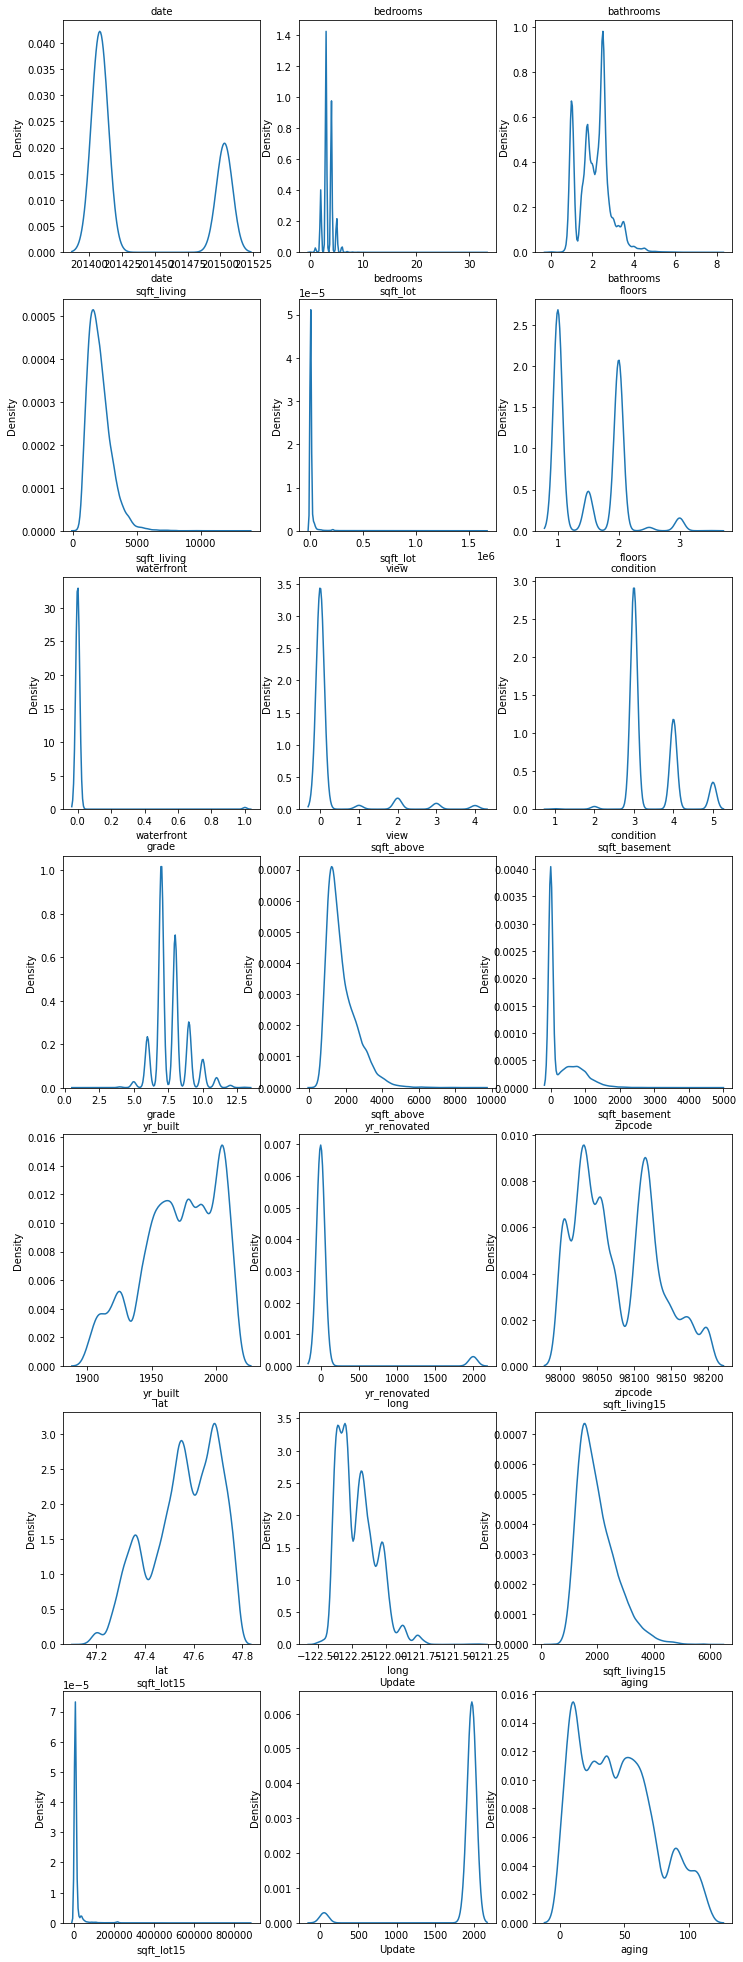

In [6]:
fig, ax = plt.subplots(7, 3, figsize=(12, 35))  # 가로 크기를 조절할 수 있습니다.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(7):
    for col in range(3):
        if count == 21:
            break
        sns.kdeplot(data=df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1

In [7]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above', 'sqft_basement', 'sqft_lot15']

def log_scaling(x, skew_columns):
    for i in skew_columns:
        x[i] = np.log1p(x[i].values)
    return x

log_scaling(df, skew_columns)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Update,aging
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0.0,0,3,7,...,0.000000,1955,0,98178,47.5112,-122.257,1340,8.639588,1955,60
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0.0,0,3,6,...,0.000000,1933,0,98028,47.7379,-122.233,2720,8.995041,1933,82
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0.0,0,3,8,...,0.000000,1987,0,98074,47.6168,-122.045,1800,8.923191,1987,28
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0.0,0,3,7,...,0.000000,1995,0,98003,47.3097,-122.327,2238,8.827615,1995,20
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0.0,0,3,7,...,0.000000,1963,0,98198,47.4095,-122.315,1650,9.181118,1963,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0.0,0,3,6,...,0.000000,2014,0,98010,47.3095,-122.002,1320,9.332912,2014,1
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0.0,0,3,8,...,0.000000,2014,0,98144,47.5699,-122.288,1400,7.115582,2014,1
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0.0,0,3,8,...,4.875197,2008,0,98116,47.5773,-122.409,1330,7.143618,2008,7
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0.0,0,3,7,...,0.000000,2009,0,98144,47.5944,-122.299,1020,7.604894,2009,6


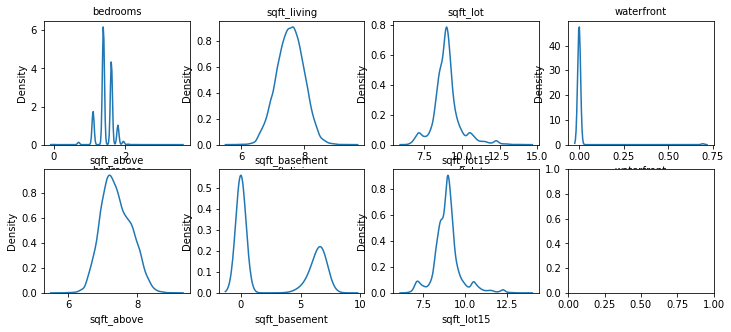

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(12, 5))

# 각 컬럼의 분포를 시각화
for i, column in enumerate(skew_columns):
    # 현재 컬럼의 위치 계산
    row = i // 4  # 행 인덱스
    col = i % 4   # 열 인덱스
    
    # KDE 플롯 그리기
    sns.kdeplot(data=df[column], ax=ax[row][col])
    
    # 그래프 제목 설정
    ax[row][col].set_title(column, fontsize=10)

In [9]:
train = df.iloc[:train_len, :]
test = df.iloc[train_len:, :] 

In [10]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Update,aging
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0.0,0,3,7,...,0.0,1955,0,98178,47.5112,-122.257,1340,8.639588,1955,60
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0.0,0,3,6,...,0.0,1933,0,98028,47.7379,-122.233,2720,8.995041,1933,82
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0.0,0,3,8,...,0.0,1987,0,98074,47.6168,-122.045,1800,8.923191,1987,28
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0.0,0,3,7,...,0.0,1995,0,98003,47.3097,-122.327,2238,8.827615,1995,20
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0.0,0,3,7,...,0.0,1963,0,98198,47.4095,-122.315,1650,9.181118,1963,52


In [11]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Update,aging
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0.0,0,3,7,...,5.993961,1951,1991,98125,47.7210,-122.319,1690,8.941153,40,64
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0.0,0,5,7,...,6.814543,1965,0,98136,47.5208,-122.393,1360,8.517393,1965,50
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0.0,0,3,11,...,7.333676,2001,0,98053,47.6561,-122.005,4760,11.532051,2001,14
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0.0,0,3,7,...,6.594413,1960,0,98146,47.5123,-122.337,1780,9.001346,1960,55
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0.0,0,3,7,...,0.000000,2003,0,98038,47.3684,-122.031,2390,8.932080,2003,12


In [12]:
train.shape, test.shape

((15035, 21), (6468, 21))

<AxesSubplot:xlabel='price', ylabel='Density'>

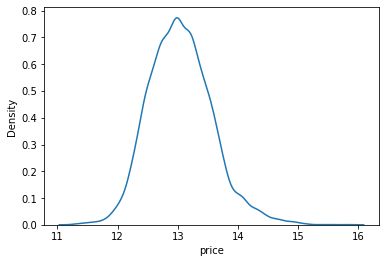

In [13]:
# y는 price
y = np.log1p(y)
sns.kdeplot(y)

# Baseline Model

In [14]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
random_state=2023

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [16]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        train_x, test_x, train_y, test_y = train_test_split(train, y, test_size=0.2, random_state=random_state)
        model.fit(train_x, train_y)
        y_pred = model.predict(test_x)
        
        df[model_name] = rmse(test_y, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,139887.471548
GradientBoostingRegressor,128616.072153
XGBRegressor,121357.841494
LGBMRegressor,116938.458338


# Tuning

In [79]:
# RandomSearch

def my_RandomSearch(model, train, y, param, n_iter=10, verbose=1, n_jobs=-1):

    # 1. GridSearchCV 모델로 `model`을 초기화합니다.
    random_model = RandomizedSearchCV(model, param_distributions=param, \
    scoring='neg_mean_squared_error', \
    n_iter = n_iter, \
    cv=10, verbose=1, n_jobs=-1)

    # 2. 모델을 fitting 합니다.
    random_model.fit(train, y)

    # 3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']

    # 4. 데이터 프레임을 생성
    results = pd.DataFrame(params)
    results["score"] = score

    # 5. RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    results['RMSLE'] = np.sqrt(-1 * results['score'])

    results = results.sort_values("RMSLE")
    return results

In [80]:
from sklearn.model_selection import RandomizedSearchCV

# 모델과 매개변수 설정
model = LGBMRegressor(random_state=2023)
param = {
    'n_estimators': range(550, 700, 10),
    'max_depth': [10, 20, 30],
}

# RandomizedSearchCV 실행
n_iter = 10  # 랜덤 탐색 횟수
random_search = RandomizedSearchCV(model, param_distributions=param, n_iter=n_iter, \
                                   cv=5, scoring='neg_mean_squared_error', random_state=random_state, \
                                   verbose=2, n_jobs=-1)
random_search.fit(train, y)

# 최적 하이퍼 파라미터 및 결과 출력
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", np.sqrt(-1 * random_search.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 570, 'max_depth': 10}
Best RMSE: 0.16205448130226513


In [71]:
# GridSearch

param = {
    'n_estimators': range(400, 600, 10),
    'max_depth': [10, 20, 30],
}

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [72]:
model = LGBMRegressor(random_state=2023)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....................max_depth=20, n_estimators=400; total time=   2.6s
[CV] END .....................max_depth=20, n_estimators=410; total time=   2.5s
[CV] END .....................max_depth=20, n_estimators=410; total time=   2.7s
[CV] END .....................max_depth=20, n_estimators=420; total time=   2.5s
[CV] END .....................max_depth=20, n_estimators=420; total time=   2.7s
[CV] END .....................max_depth=20, n_estimators=420; total time=   2.8s
[CV] END .....................max_depth=20, n_estimators=430; total time=   2.6s
[CV] END .....................max_depth=20, n_estimators=430; total time=   2.8s
[CV] END .....................max_depth=20, n_estimators=440; total time=   2.9s
[CV] END .....................max_depth=20, n_estimators=440; total time=   2.6s
[CV] END .....................max_depth=20, n_estimators=440; total time=   2.8s
[CV] END .....................max_depth=20, n_e

,max_depth,n_estimators,score,RMSLE
11,10,510,-0.026233,0.161966
10,10,500,-0.026239,0.161984
13,10,530,-0.026242,0.161995
5,10,450,-0.026242,0.161995
14,10,540,-0.026244,0.162000
12,10,520,-0.026251,0.162021
9,10,490,-0.026252,0.162023
6,10,460,-0.026253,0.162027
8,10,480,-0.026254,0.162030
7,10,470,-0.026256,0.162036


- RandomSearch (n_estimators : (range(550, 700, 10), max_depth : [10, 20, 30])
    - Best Parameters: {'n_estimators': 570, 'max_depth': 10}
    - Best RMSE: 0.16205448130226513
    
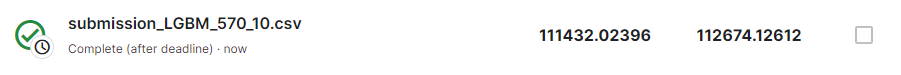

- GridSearch (n_estimators : (range(400, 600, 10), max_depth : [10, 20, 30])
    - Best Parameters: {'n_estimators': 510, 'max_depth': 10}
    - Best RMSE: 0.161966
    
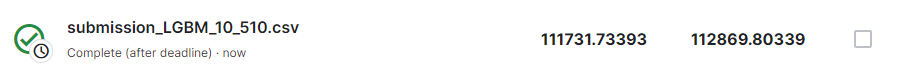



In [81]:
model = LGBMRegressor(max_depth=10, n_estimators=570, random_state=2023)
model.fit(train, y)
prediction = np.expm1(model.predict(test))
prediction

array([ 504261.40811756,  496063.24055055, 1331279.70654721, ...,
        482033.22070808,  321622.11169547,  453321.47753737])

In [82]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
n_estimators_value = model.get_params()['n_estimators']
max_depth_value = model.get_params()['max_depth']
file_name = f"submission_LGBM_{n_estimators_value}_{max_depth_value}.csv"
submission.to_csv(file_name, index=False)

[CV] END .....................max_depth=20, n_estimators=610; total time=   3.6s
[CV] END .....................max_depth=20, n_estimators=610; total time=   3.5s
[CV] END .....................max_depth=20, n_estimators=610; total time=   3.8s
[CV] END .....................max_depth=20, n_estimators=690; total time=   4.4s
[CV] END .....................max_depth=20, n_estimators=690; total time=   4.0s
[CV] END .....................max_depth=10, n_estimators=570; total time=   3.4s
[CV] END .....................max_depth=10, n_estimators=570; total time=   3.2s
[CV] END .....................max_depth=10, n_estimators=570; total time=   3.2s
[CV] END .....................max_depth=30, n_estimators=560; total time=   3.6s
[CV] END .....................max_depth=30, n_estimators=560; total time=   3.3s
[CV] END .....................max_depth=10, n_estimators=640; total time=   3.9s
[CV] END .....................max_depth=10, n_estimators=640; total time=   3.7s
[CV] END ...................

# 회고

In [ ]:
randomsearch와 gridsearch를 가지고 여러 파라미터를 실험해보았습니다.
여러 파라미터값에서 점수가 낮아진다는 것을 파악하여 파라미터를 더 조정을 해보았지만 점수가 더 높아져서 만지면 만질수록 점수가 안좋아지고 좋아지고를 반복하여 어떨때 좋아지는지를 파악해야하는데 너무 일정하지가 않아 고민을 많이했습니다.

그루님들과 원인을 파악해보고싶습니다.